## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/12p5yr_stochastic_analysis/blob/master/tutorials/model_selection.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [ ]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions la_forge
!git clone https://github.com/AaronDJohnson/12p5yr_stochastic_analysis
import sys
sys.path.insert(0,'/content/12p5yr_stochastic_analysis/tutorials')

# Using `enterprise` to perform model selection

In this notebook you will learn:
* How to use `enterprise_extensions` to create models with NANOGrav data,
* How to perform model selection on the NANOGrav 15-year data set using `HyperModel`.
* How to reproduce some of Figure 2 of the NANOGrav 15-year GWB paper

# Load packages and modules

In [83]:
%%capture
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import json, sys, glob
import matplotlib.pyplot as plt
import numpy as np

from enterprise_extensions import models, model_utils, hypermodel

from h5pulsar.pulsar import FilePulsar

from la_forge import core, slices, bfacs

IN_COLAB = 'google.colab' in sys.modules

In [2]:
if IN_COLAB:
    datadir = '/content/12p5yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

## Load the full set of Pulsar objects

  * These files have been stored as `HDF5` files to make them much faster to load (and take up little space)
  
  * See the `explore_data.ipynb` tutorial to see what exists in these files and how to load `.par` and `.tim` files

In [3]:
psrs = []
for hdf5_file in glob.glob(datadir + '/hdf5/*.hdf5'):
    psrs.append(FilePulsar(hdf5_file))
print('Loaded {0} pulsars from hdf5 files'.format(len(psrs)))

Loaded 67 pulsars from hdf5 files


## Read in white noise dictionaries
  * We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 

  * In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches to reduce the computational cost of the analysis significantly.

  * The noise properties have been stored as `json` files, and are read into a big parameter dictionary.

In [4]:
## Get parameter noise dictionary
noise_ng15 = datadir + '/15yr_wn_dict.json'

wn_params = {}
with open(noise_ng15, 'r') as fp:
    wn_params.update(json.load(fp))

# Model Selection: `model_2a` vs. `model_3a`

* This notebook reproduces one of the Bayes factors found in figure 2 of the 15-year GWB analysis paper

* We want to be able to compute the Bayes factor for a signal in the data. This can be done using the `HyperModel` class, where we choose between a `model_2a` with a common (but uncorrelated) red process in the pulsars, and `model_3a` with a common, HD correlated red process among all pulsars

In [5]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_2a(psrs, noisedict=wn_params, n_gwbfreqs=14,
                         tm_marg=True, tm_svd=True)
pta[1] = models.model_3a(psrs, noisedict=wn_params, n_gwbfreqs=14,
                         tm_marg=True, tm_svd=True)

* In setting up the `HyperModel` in the next cell, we set weights to make the models sample more evenly.
* `log_weights` is a list with the same length as the number of models, and each entry is added to the corresponding log-likelihood
* We will undo the `log_weights` later in post-processing the chains

In [6]:
super_model = hypermodel.HyperModel(pta, log_weights=[np.log(300), 0])

In [7]:
if IN_COLAB:
    outDir = '/content/15yr_stochastic_analysis/tutorials/chains/ms_2a3a_chains'
else:
    outDir = './chains/ms_2a3a_chains'
sampler = super_model.setup_sampler(resume=True, outdir=outDir, sample_nmodel=True,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



In [8]:
# sampler for N steps
N = int(5e6)  # 5e6 is a good number for a real analysis
x0 = super_model.initial_sample()

In [ ]:
# sample
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [28]:
c1 = core.Core('/Users/aaron/Documents/GitHub/15yr_stochastic_analysis/tutorials/chains/M2A[4.33][HD]M3A[4.33] 2')

[]

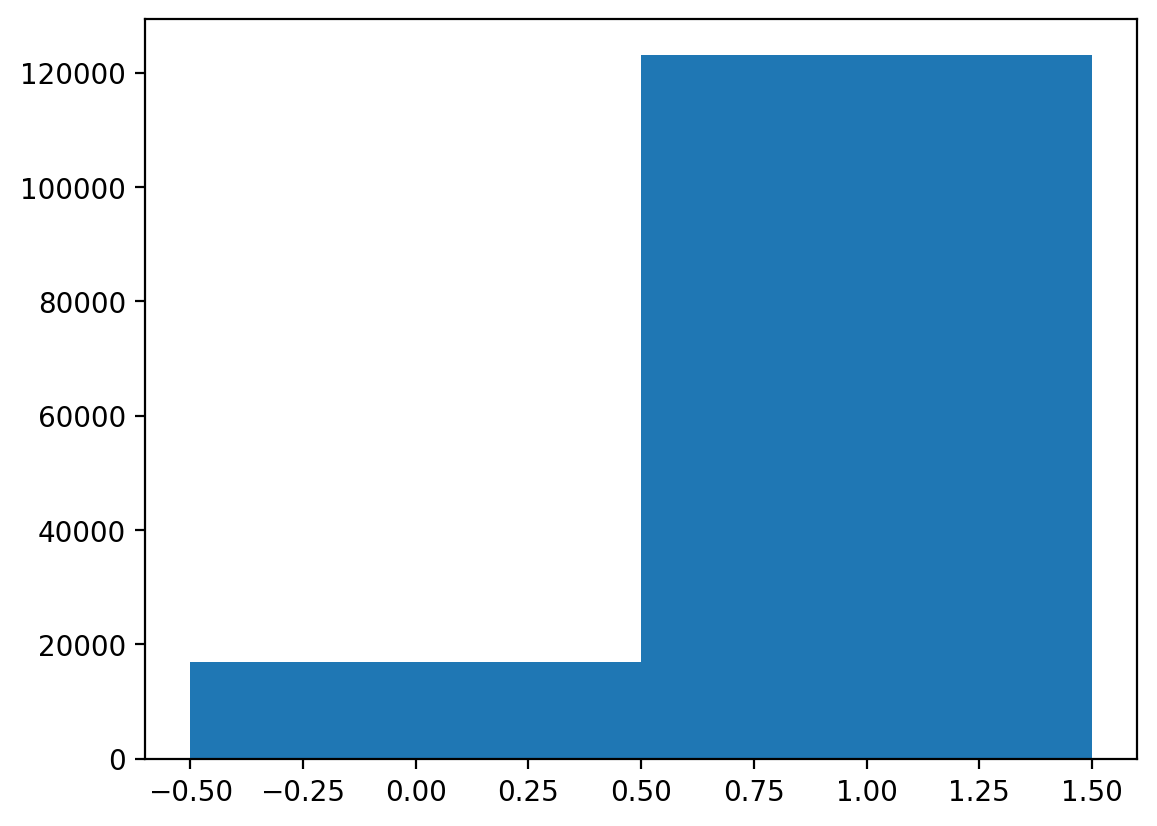

In [29]:
res = plt.hist(c1.get_param('nmodel'), bins=2)
plt.plot()

In [34]:
(res[0][1] / res[0][0])

7.283568852362088

## Thermodynamic Integration

* Here we show how to perform thermodynamic integration with `enterprise_extensions`, `PTMCMCSampler` and `la_forge`
* The sampling cannot be easily performed in a `Jupyter Notebook`, so we include a file named `ti_sample.py` to show how to do the sampling.
* Warning: This procedure is very expensive and will require a lot of memory
* Chains have been included here so that you do not have to do the sampling yourself

* These cores only contain the likelihood chains for each of 31 temperatures
* The likelihood is raised to a power of $1/T$ for each chain and swaps are proposed between them: $p(\vec{\eta} \mid \delta \vec{t}) \propto \mathcal{L}( \delta \vec{t} \mid \vec{\eta})^{1/T} \pi(\vec{\eta})$
* Using this, we can compute the evidence by seeing how the average log likelihood changes at each temperature

In [85]:
# load core objects containing all the 
m2a_ti = slices.SlicesCore(corepath='./presampled_cores/m2a_ti.core')
m3a_ti = slices.SlicesCore(corepath='./presampled_cores/m3a_ti.core')

In [86]:
# compute log_evidence for CURN and HD models
lnZ_2a = bfacs.ti_log_evidence(m2a_ti)
lnZ_3a = bfacs.ti_log_evidence(m3a_ti)


model:
ln(evidence) = 7973027.563121095
error in ln_Z = 0.1302538396311996


model:
ln(evidence) = 7973032.851552832
error in ln_Z = 0.18722950911187358



In [88]:
# Use evidences to compute a Bayes factor
# scale can return this number as a log or unit scale value
bfacs.log10_bf(lnZ_2a, lnZ_3a, scale='1')

/Users/aaron/Documents/GitHub/la_forge/la_forge/bfacs.py:85: UserWarning: Obsolete: either use ufloat(nominal_value, std_dev), ufloat(nominal_value, std_dev, tag), or the ufloat_fromstr() function, for string representations. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  log_evidence1 = ufloat(log_ev1)
/Users/aaron/Documents/GitHub/la_forge/la_forge/bfacs.py:86: UserWarning: Obsolete: either use ufloat(nominal_value, std_dev), ufloat(nominal_value, std_dev, tag), or the ufloat_fromstr() function, for string representations. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  log_evidence2 = ufloat(log_ev2)


(198.03261446315148, 45.16748075936892)

### Plot the average log likelihood over inverse temperature

* Here we see the spacing of the inverse temperatures on a log scale
* An infinite temperature is also included which corresponds to sampling the prior
* The maximum temperature should be approximately horizontal with the infinite temperature
* Making this connection is important so that we get good swaps between the infinite temperature chain

* Further, we can be sure that we have a large enough range of temperatures to compute the evidence integral

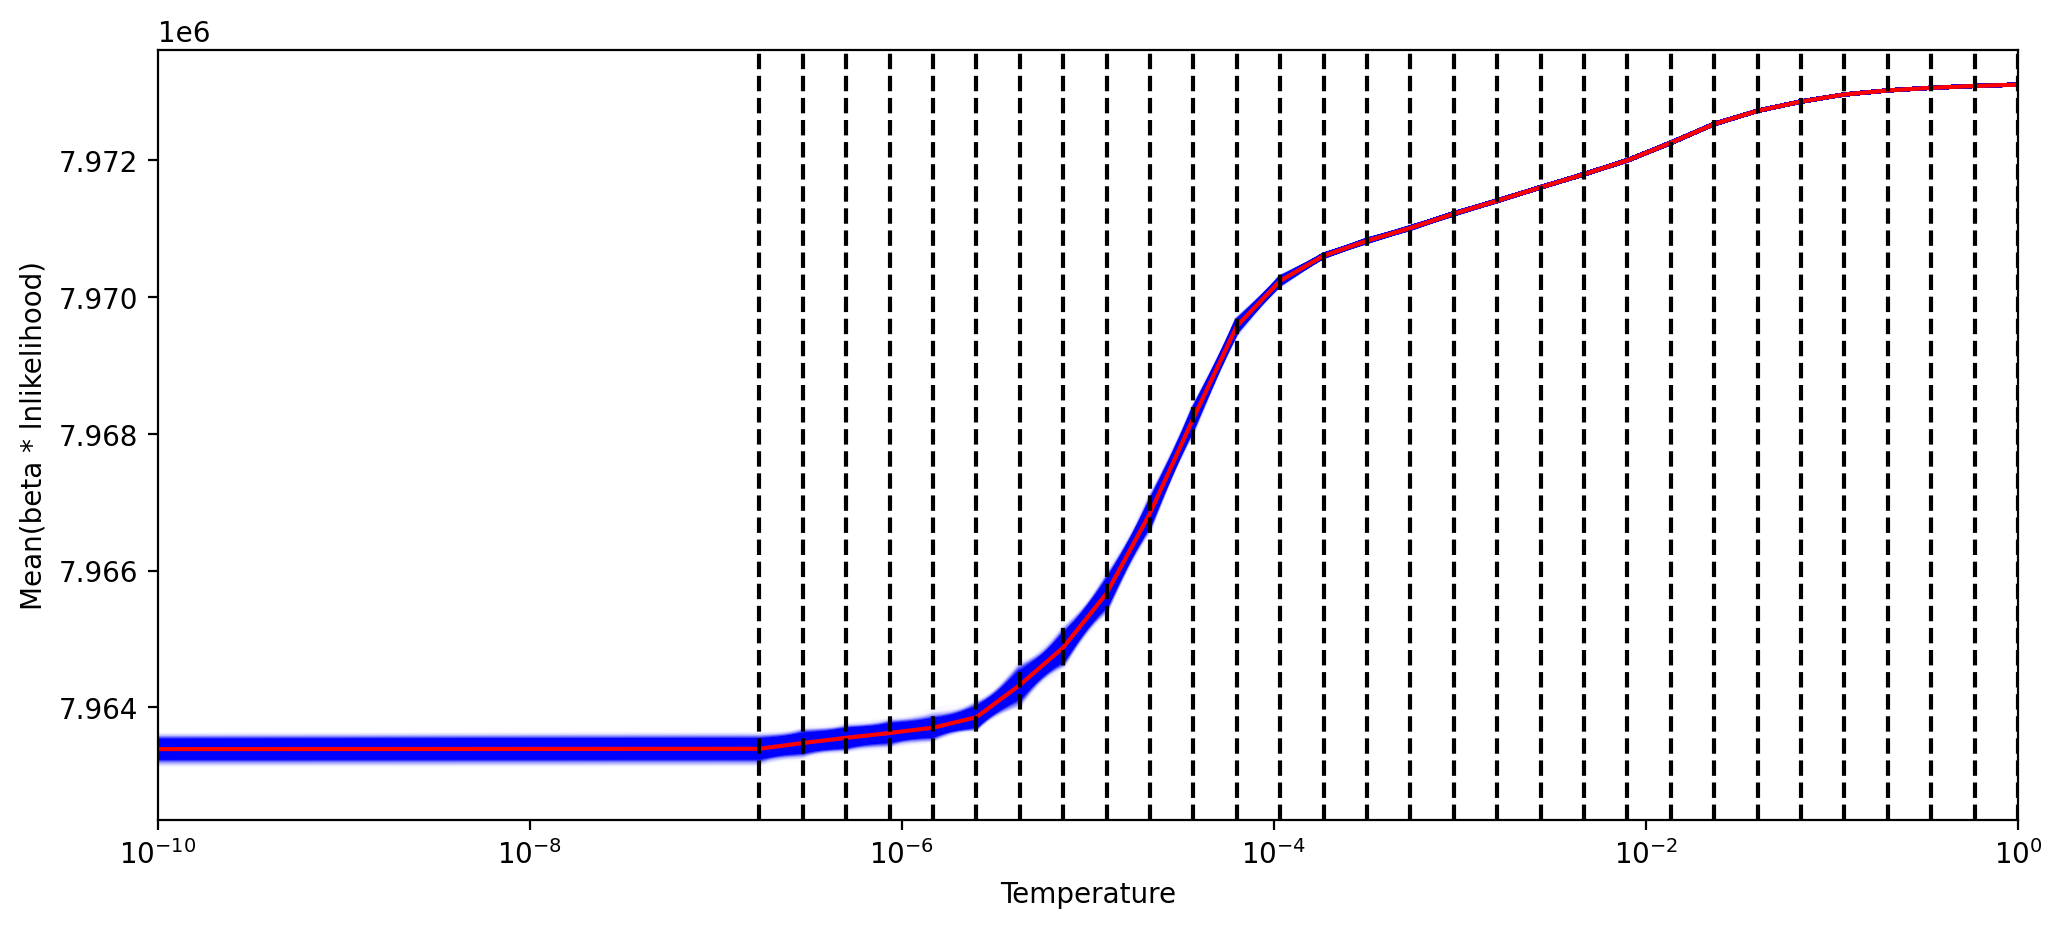


model:
ln(evidence) = 7973027.567148067
error in ln_Z = 0.13143612938284965



<Figure size 640x480 with 0 Axes>

In [92]:
res = bfacs.ti_log_evidence(m2a_ti, plot=True)

* Here we have reproduced one part of Figure 2 in the 15-year GWB analysis

* We used the `HyperModel` framework
* and thermodynamic integration
* to compute Bayes factors between two models: CURN and HD correlated models